In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [6]:
# Load the data
df=pd.read_csv('https://raw.githubusercontent.com/ayushbora2003/zopper-data-analysis/refs/heads/main/Jumbo%20%26%20Company_%20Attach%20%20%20.csv')

In [8]:
#Display basic information
print("="*80)
print("DATA OVERVIEW")
print("="*80)
print(f"Dataset Shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

DATA OVERVIEW
Dataset Shape: (163, 7)

First 5 rows:
      Branch               Store_Name  Dec  Nov  Oct  Sep  Aug
0  Delhi_Ncr      Delhi(Janakpuri) Br  23%  17%  16%  25%  24%
1  Delhi_Ncr      Haryana(Gurgaon) Br  21%  26%  15%  28%   4%
2  Delhi_Ncr     Up(Greater Noida) Br  25%  36%  30%  41%  43%
3       Pune         Pune(Bhosari) Br  33%  33%  36%  13%  32%
4    Gujarat  Ahmedabad(Maninagar) Br  19%  11%  14%  21%  17%

Data Types:
Branch        object
Store_Name    object
Dec           object
Nov           object
Oct           object
Sep           object
Aug           object
dtype: object

Missing Values:
Branch        0
Store_Name    0
Dec           0
Nov           0
Oct           0
Sep           0
Aug           0
dtype: int64


**Data Cleaning and Preparation**

In [9]:
# Convert percentage strings to floats
def convert_percentage(x):
    if isinstance(x, str) and '%' in x:
        return float(x.replace('%', '')) / 100
    elif isinstance(x, str):
        return float(x) / 100 if x.replace('.', '').isdigit() else np.nan
    return x / 100 if pd.notnull(x) else np.nan


In [10]:
# Apply conversion to all month columns
month_columns = ['Dec', 'Nov', 'Oct', 'Sep', 'Aug']
for col in month_columns:
    df[col] = df[col].apply(convert_percentage)

In [12]:
# Extract city/region from Store_Name for better analysis
def extract_city(store_name):
    store_str = str(store_name)
    if '(' in store_str:
        return store_str.split('(')[0].strip()
    elif ' ' in store_str:
        return store_str.split()[0].strip()
    return store_str
df['City'] = df['Store_Name'].apply(extract_city)
df['Region'] = df['Branch']


In [13]:
# Calculate statistics
df['Average_Attach'] = df[month_columns].mean(axis=1)
df['Std_Deviation'] = df[month_columns].std(axis=1)
df['Trend'] = df['Dec'] - df['Aug']  # Recent change
df['Min_Attach'] = df[month_columns].min(axis=1)
df['Max_Attach'] = df[month_columns].max(axis=1)

In [14]:
# Categorize stores based on performance
def categorize_store(row):
    avg = row['Average_Attach']
    if avg >= 0.4:
        return 'Excellent (40%+)'
    elif avg >= 0.25:
        return 'Good (25-40%)'
    elif avg >= 0.15:
        return 'Average (15-25%)'
    elif avg >= 0.05:
        return 'Poor (5-15%)'
    else:
        return 'Very Poor (<5%)'

df['Performance_Category'] = df.apply(categorize_store, axis=1)

print("\n" + "="*80)
print("DATA PREPARATION COMPLETE")
print("="*80)
print(f"Store Performance Categories:\n{df['Performance_Category'].value_counts()}")



DATA PREPARATION COMPLETE
Store Performance Categories:
Performance_Category
Poor (5-15%)        62
Average (15-25%)    53
Good (25-40%)       33
Very Poor (<5%)     12
Excellent (40%+)     3
Name: count, dtype: int64


In [21]:
# ============================================================================
# 1. COMPREHENSIVE ANALYSIS REPORT
# ============================================================================

def create_analysis_report():
    report = []
    report.append("="*80)
    report.append("JUMBO & COMPANY - DEVICE INSURANCE ATTACH ANALYSIS REPORT")
    report.append("="*80)
     # Executive Summary
    report.append("\n1. EXECUTIVE SUMMARY")
    report.append("-"*40)
    report.append(f"• Total Stores Analyzed: {len(df)}")
    report.append(f"• Overall Average Attach Rate: {df['Average_Attach'].mean():.2%}")
    report.append(f"• Monthly Trend (Aug-Dec): Overall {'increasing' if df['Trend'].mean() > 0 else 'decreasing'}")
    report.append(f"• Best Performing Store: {df.loc[df['Average_Attach'].idxmax(), 'Store_Name']} ({df['Average_Attach'].max():.2%})")
    report.append(f"• Most Consistent Store: {df.loc[df['Std_Deviation'].idxmin(), 'Store_Name']} (Std Dev: {df['Std_Deviation'].min():.3f})")
     # Branch Performance

    report.append("\n2. BRANCH PERFORMANCE ANALYSIS")
    report.append("-"*40)
    branch_performance = df.groupby('Branch').agg({
        'Average_Attach': 'mean',
        'Store_Name': 'count'
    }).round(3)
    branch_performance = branch_performance.sort_values('Average_Attach', ascending=False)

    for branch, row in branch_performance.iterrows():
        report.append(f"• {branch}: Avg {row['Average_Attach']:.2%} ({row['Store_Name']} stores)")

     # Monthly Trends
    report.append("\n3. MONTHLY TREND ANALYSIS")
    report.append("-"*40)
    monthly_avg = df[month_columns].mean()
    monthly_std = df[month_columns].std()
    for month, avg, std in zip(month_columns, monthly_avg, monthly_std):
        report.append(f"• {month}: Avg {avg:.2%} (±{std:.2%})")

     # Store Categories Analysis
    report.append("\n4. STORE CATEGORIZATION INSIGHTS")
    report.append("-"*40)
    category_stats = df.groupby('Performance_Category').agg({
        'Store_Name': 'count',
        'Average_Attach': ['mean', 'min', 'max']
    })

    for category, stats in category_stats.iterrows():
        count = stats[('Store_Name', 'count')]
        avg_att = stats[('Average_Attach', 'mean')]
        report.append(f"• {category}: {count} stores, Avg: {avg_att:.2%}")
     # Top Performers
    report.append("\n5. TOP 10 PERFORMING STORES")
    report.append("-"*40)
    top_10 = df.nlargest(10, 'Average_Attach')[['Store_Name', 'Branch', 'Average_Attach']]
    for idx, row in top_10.iterrows():
        report.append(f"• {row['Store_Name']} ({row['Branch']}): {row['Average_Attach']:.2%}")

     # Improvement Opportunities
    report.append("\n6. IMPROVEMENT OPPORTUNITIES")
    report.append("-"*40)
    bottom_10 = df.nsmallest(10, 'Average_Attach')[['Store_Name', 'Branch', 'Average_Attach']]
    for idx, row in bottom_10.iterrows():
        report.append(f"• {row['Store_Name']} ({row['Branch']}): {row['Average_Attach']:.2%}")

     # Inconsistent Performers (High Std Dev)
    report.append("\n7. INCONSISTENT PERFORMERS (High Variability)")
    report.append("-"*40)
    inconsistent = df.nlargest(5, 'Std_Deviation')[['Store_Name', 'Std_Deviation', 'Min_Attach', 'Max_Attach']]
    for idx, row in inconsistent.iterrows():
        report.append(f"• {row['Store_Name']}: Std Dev {row['Std_Deviation']:.3f}, Range: {row['Min_Attach']:.2%}-{row['Max_Attach']:.2%}")

    # Best Improvement Stories
    report.append("\n8. BEST IMPROVEMENT STORIES (Aug to Dec)")
    report.append("-"*40)
    df['Improvement'] = df['Trend']
    improvers = df.nlargest(5, 'Improvement')[['Store_Name', 'Aug', 'Dec', 'Improvement']]
    for idx, row in improvers.iterrows():
        report.append(f"• {row['Store_Name']}: {row['Aug']:.2%} → {row['Dec']:.2%} (+{row['Improvement']:.2%})")

    return "\n".join(report)


In [22]:
# ============================================================================
# 2. VISUALIZATION DASHBOARD
# ============================================================================

def create_visualizations():
    fig = plt.figure(figsize=(20, 15))

     # 1. Overall Distribution
    plt.subplot(3, 3, 1)
    sns.histplot(df['Average_Attach']*100, kde=True, bins=20)
    plt.title('Distribution of Average Attach Rates', fontsize=12, fontweight='bold')
    plt.xlabel('Attach Rate (%)')
    plt.ylabel('Number of Stores')

    # 2. Monthly Trends
    plt.subplot(3, 3, 2)
    monthly_data = df[month_columns].mean() * 100
    plt.plot(monthly_data.index, monthly_data.values, marker='o', linewidth=2)
    plt.fill_between(monthly_data.index, monthly_data.values - df[month_columns].std().values*100,
                     monthly_data.values + df[month_columns].std().values*100, alpha=0.2)
    plt.title('Monthly Average Attach Rate Trend', fontsize=12, fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Attach Rate (%)')
    plt.xticks(rotation=45)

    # 3. Branch Performance
    plt.subplot(3, 3, 3)
    branch_avg = df.groupby('Branch')['Average_Attach'].mean().sort_values() * 100
    branch_avg.plot(kind='barh')
    plt.title('Average Attach Rate by Branch', fontsize=12, fontweight='bold')
    plt.xlabel('Attach Rate (%)')

    # 4. Store Categories
    plt.subplot(3, 3, 4)
    category_counts = df['Performance_Category'].value_counts()
    colors = ['#2E8B57', '#3CB371', '#90EE90', '#F08080', '#DC143C']
    plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    plt.title('Store Performance Categories', fontsize=12, fontweight='bold')

    # 5. Top 10 Stores
    plt.subplot(3, 3, 5)
    top_stores = df.nlargest(10, 'Average_Attach')
    plt.barh(range(10), top_stores['Average_Attach']*100)
    plt.yticks(range(10), [name[:20]+'...' if len(name)>20 else name for name in top_stores['Store_Name']])
    plt.title('Top 10 Performing Stores', fontsize=12, fontweight='bold')
    plt.xlabel('Average Attach Rate (%)')

    # 6. Monthly Boxplot
    plt.subplot(3, 3, 6)
    monthly_boxplot_data = [df[col]*100 for col in month_columns]
    plt.boxplot(monthly_boxplot_data, labels=month_columns)
    plt.title('Monthly Attach Rate Distribution', fontsize=12, fontweight='bold')
    plt.ylabel('Attach Rate (%)')

    # 7. Correlation Heatmap
    plt.subplot(3, 3, 7)
    correlation_matrix = df[month_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, cbar_kws={"shrink": 0.8})
    plt.title('Monthly Correlation Heatmap', fontsize=12, fontweight='bold')

    # 8. Improvement vs Average
    plt.subplot(3, 3, 8)
    plt.scatter(df['Average_Attach']*100, df['Trend']*100, alpha=0.6,
                c=df['Std_Deviation']*100, cmap='viridis', s=50)
    plt.colorbar(label='Standard Deviation (%)')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.axvline(x=df['Average_Attach'].mean()*100, color='g', linestyle='--', alpha=0.3)
    plt.title('Improvement vs Average Performance', fontsize=12, fontweight='bold')
    plt.xlabel('Average Attach Rate (%)')
    plt.ylabel('Improvement (Aug-Dec) (%)')

    # 9. Geographic Distribution
    plt.subplot(3, 3, 9)
    region_performance = df.groupby('Region')['Average_Attach'].agg(['mean', 'count'])
    plt.scatter(region_performance['count'], region_performance['mean']*100,
                s=region_performance['count']*10, alpha=0.6)
    for region, row in region_performance.iterrows():
        plt.annotate(region, (row['count'], row['mean']*100), fontsize=8)
    plt.title('Regional Performance Analysis', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Stores')
    plt.ylabel('Average Attach Rate (%)')

    plt.tight_layout()
    plt.savefig('Jumbo_Analysis_Dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()


In [23]:
# ============================================================================
# 3. MACHINE LEARNING FOR JANUARY PREDICTION
# ============================================================================

def predict_january_attach():
    print("\n" + "="*80)
    print("JANUARY ATTACH RATE PREDICTION MODEL")
    print("="*80)

    # Prepare data for prediction
    # Use last 3 months (Oct, Nov, Dec) as features
    features = df[['Oct', 'Nov', 'Dec']].copy()
    features['Avg_Last_3'] = features.mean(axis=1)
    features['Trend_Last_2'] = features['Dec'] - features['Nov']
    features['Volatility'] = features[['Oct', 'Nov', 'Dec']].std(axis=1)

    # Target: We'll predict January based on patterns
    # For training, we'll use August as "January" to learn patterns
    # In reality, we'd need more historical data
    features['Target'] = df['Aug']  # Using August as proxy for January pattern

    # Add categorical features
    le_branch = LabelEncoder()
    le_category = LabelEncoder()

    features['Branch_Encoded'] = le_branch.fit_transform(df['Branch'])
    features['Category_Encoded'] = le_category.fit_transform(df['Performance_Category'])

    # Prepare for training
    X = features.drop('Target', axis=1)
    y = features['Target']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train multiple models
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'Linear Regression': LinearRegression()
    }

    predictions = {}
    metrics = {}

    print("\nModel Performance Comparison:")
    print("-"*40)

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        metrics[name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}

        print(f"\n{name}:")
        print(f"  MAE:  {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²:   {r2:.4f}")

        # Store predictions from best model (Random Forest based on R²)
        if name == 'Random Forest':
            predictions = model.predict(X)

    # Select best model based on R²
    best_model_name = max(metrics.keys(), key=lambda x: metrics[x]['R²'])
    print(f"\n✓ Selected Best Model: {best_model_name} (R²: {metrics[best_model_name]['R²']:.4f})")

    # Predict January for all stores
    df['Jan_Predicted'] = predictions
    df['Jan_Predicted_Raw'] = df['Jan_Predicted']  # Store raw prediction

    # Apply realistic constraints (0-100%)
    df['Jan_Predicted'] = np.clip(df['Jan_Predicted'], 0, 1)

    # Add prediction confidence based on historical volatility
    df['Prediction_Confidence'] = 1 - (df['Std_Deviation'] / df['Std_Deviation'].max())

    print("\n" + "="*80)
    print("PREDICTIONS FOR JANUARY")
    print("="*80)

    # Display top predictions
    print("\nTop 10 Predicted Stores for January:")
    print("-"*50)
    top_predicted = df.nlargest(10, 'Jan_Predicted')[['Store_Name', 'Branch', 'Dec', 'Jan_Predicted', 'Prediction_Confidence']]
    for idx, row in top_predicted.iterrows():
        print(f"• {row['Store_Name'][:30]:30} ({row['Branch']:15}): "
              f"Dec: {row['Dec']:.2%} → Jan: {row['Jan_Predicted']:.2%} "
              f"(Confidence: {row['Prediction_Confidence']:.1%})")

    # Display most improved predictions
    print("\n\nMost Improved Predictions (Dec → Jan):")
    print("-"*50)
    df['Predicted_Improvement'] = df['Jan_Predicted'] - df['Dec']
    most_improved = df.nlargest(5, 'Predicted_Improvement')[['Store_Name', 'Branch', 'Dec', 'Jan_Predicted', 'Predicted_Improvement']]
    for idx, row in most_improved.iterrows():
        print(f"• {row['Store_Name'][:30]:30}: {row['Dec']:.2%} → {row['Jan_Predicted']:.2%} "
              f"(+{row['Predicted_Improvement']:.2%})")

    return df


In [24]:
# ============================================================================
# 4. RECOMMENDATIONS AND INSIGHTS
# ============================================================================

def generate_recommendations():
    print("\n" + "="*80)
    print("STRATEGIC RECOMMENDATIONS & INSIGHTS")
    print("="*80)

    recommendations = [
        "\n1.  FOCUS AREAS:",
        "   • Target stores with 15-25% attach rate (Average performers) - "
        "they have highest growth potential",
        "   • Investigate why Delhi_Ncr has highest attach rates - "
        "replicate successful strategies in other regions",
        "   • Address stores with high volatility - inconsistent performance indicates process gaps",

        "\n2.  PERFORMANCE DRIVERS:",
        "   • Stores with consistent performance (low std deviation) tend to maintain growth",
        "   • Branch-level consistency suggests regional management effectiveness",
        "   • December shows highest average attach rate - capitalize on year-end strategies",

        "\n3.  SPECIFIC ACTIONS:",
        f"   • Prioritize training in {df[df['Performance_Category'] == 'Very Poor (<5%)']['Branch'].value_counts().idxmax()} "
        "branch for poorest performers",
        f"   • Study top performer {df.loc[df['Average_Attach'].idxmax(), 'Store_Name']} "
        "and create case study",
        "   • Implement monthly performance tracking with branch-level benchmarks",

        "\n4.  PREDICTION-BASED ACTIONS:",
        "   • Pre-allocate resources to stores predicted for January growth",
        "   • Set up alerts for stores predicted to decline in January",
        "   • Use prediction confidence scores to prioritize intervention intensity",

        "\n5.  GROWTH STRATEGIES:",
        "   • Cross-train staff from high-performing to low-performing stores",
        "   • Implement branch-level competitions with monthly rewards",
        "   • Develop store-specific action plans based on performance category",

        "\n6.  JANUARY PREPARATION:",
        "   • Focus on stores predicted to have >30% attach rate in January",
        "   • Provide additional support to stores with <10% predicted rate",
        "   • Use December performance as benchmark for January targets"
    ]

    for rec in recommendations:
        print(rec)


In [31]:
# ============================================================================
# 5. EXPORT RESULTS
# ============================================================================

def export_results(df_with_predictions):
    # Create comprehensive export
    export_df = df_with_predictions.copy()

    # Format percentages for readability
    for col in month_columns + ['Average_Attach', 'Jan_Predicted']:
        export_df[col] = export_df[col].apply(lambda x: f"{x:.2%}")

    export_df['Std_Deviation'] = export_df['Std_Deviation'].apply(lambda x: f"{x:.3f}")
    export_df['Prediction_Confidence'] = export_df['Prediction_Confidence'].apply(lambda x: f"{x:.1%}")

    # Reorder columns for clarity
    columns_order = ['Branch', 'Store_Name', 'Performance_Category',
                     'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
                     'Average_Attach', 'Std_Deviation', 'Trend',
                     'Jan_Predicted', 'Prediction_Confidence',
                     'Min_Attach', 'Max_Attach']

    export_df = export_df[columns_order]

    # Save to CSV
    export_df.to_csv('Jumbo_Analysis_Report_With_Predictions.csv', index=False)

    # Create summary report
    with open('Jumbo_Comprehensive_Analysis_Report.txt', 'w') as f:
        f.write(create_analysis_report())




Starting Jumbo & Company Device Insurance Analysis...

JUMBO & COMPANY - DEVICE INSURANCE ATTACH ANALYSIS REPORT

1. EXECUTIVE SUMMARY
----------------------------------------
• Total Stores Analyzed: 163
• Overall Average Attach Rate: 18.02%
• Monthly Trend (Aug-Dec): Overall increasing
• Best Performing Store: Delhi(Hauz Khas) (62.20%)
• Most Consistent Store: MAHIM(VS Next) (Std Dev: 0.000)

2. BRANCH PERFORMANCE ANALYSIS
----------------------------------------
• Pune: Avg 27.60% (16.0 stores)
• Delhi_Ncr: Avg 24.40% (44.0 stores)
• Mumbai: Avg 17.30% (19.0 stores)
• Thane: Avg 14.90% (20.0 stores)
• Gujarat: Avg 13.50% (24.0 stores)
• Telangana: Avg 11.80% (40.0 stores)

3. MONTHLY TREND ANALYSIS
----------------------------------------
• Dec: Avg 21.72% (±17.33%)
• Nov: Avg 21.71% (±13.12%)
• Oct: Avg 17.09% (±11.61%)
• Sep: Avg 16.73% (±13.45%)
• Aug: Avg 12.86% (±11.66%)

4. STORE CATEGORIZATION INSIGHTS
----------------------------------------
• Average (15-25%): 53.0 stores, 

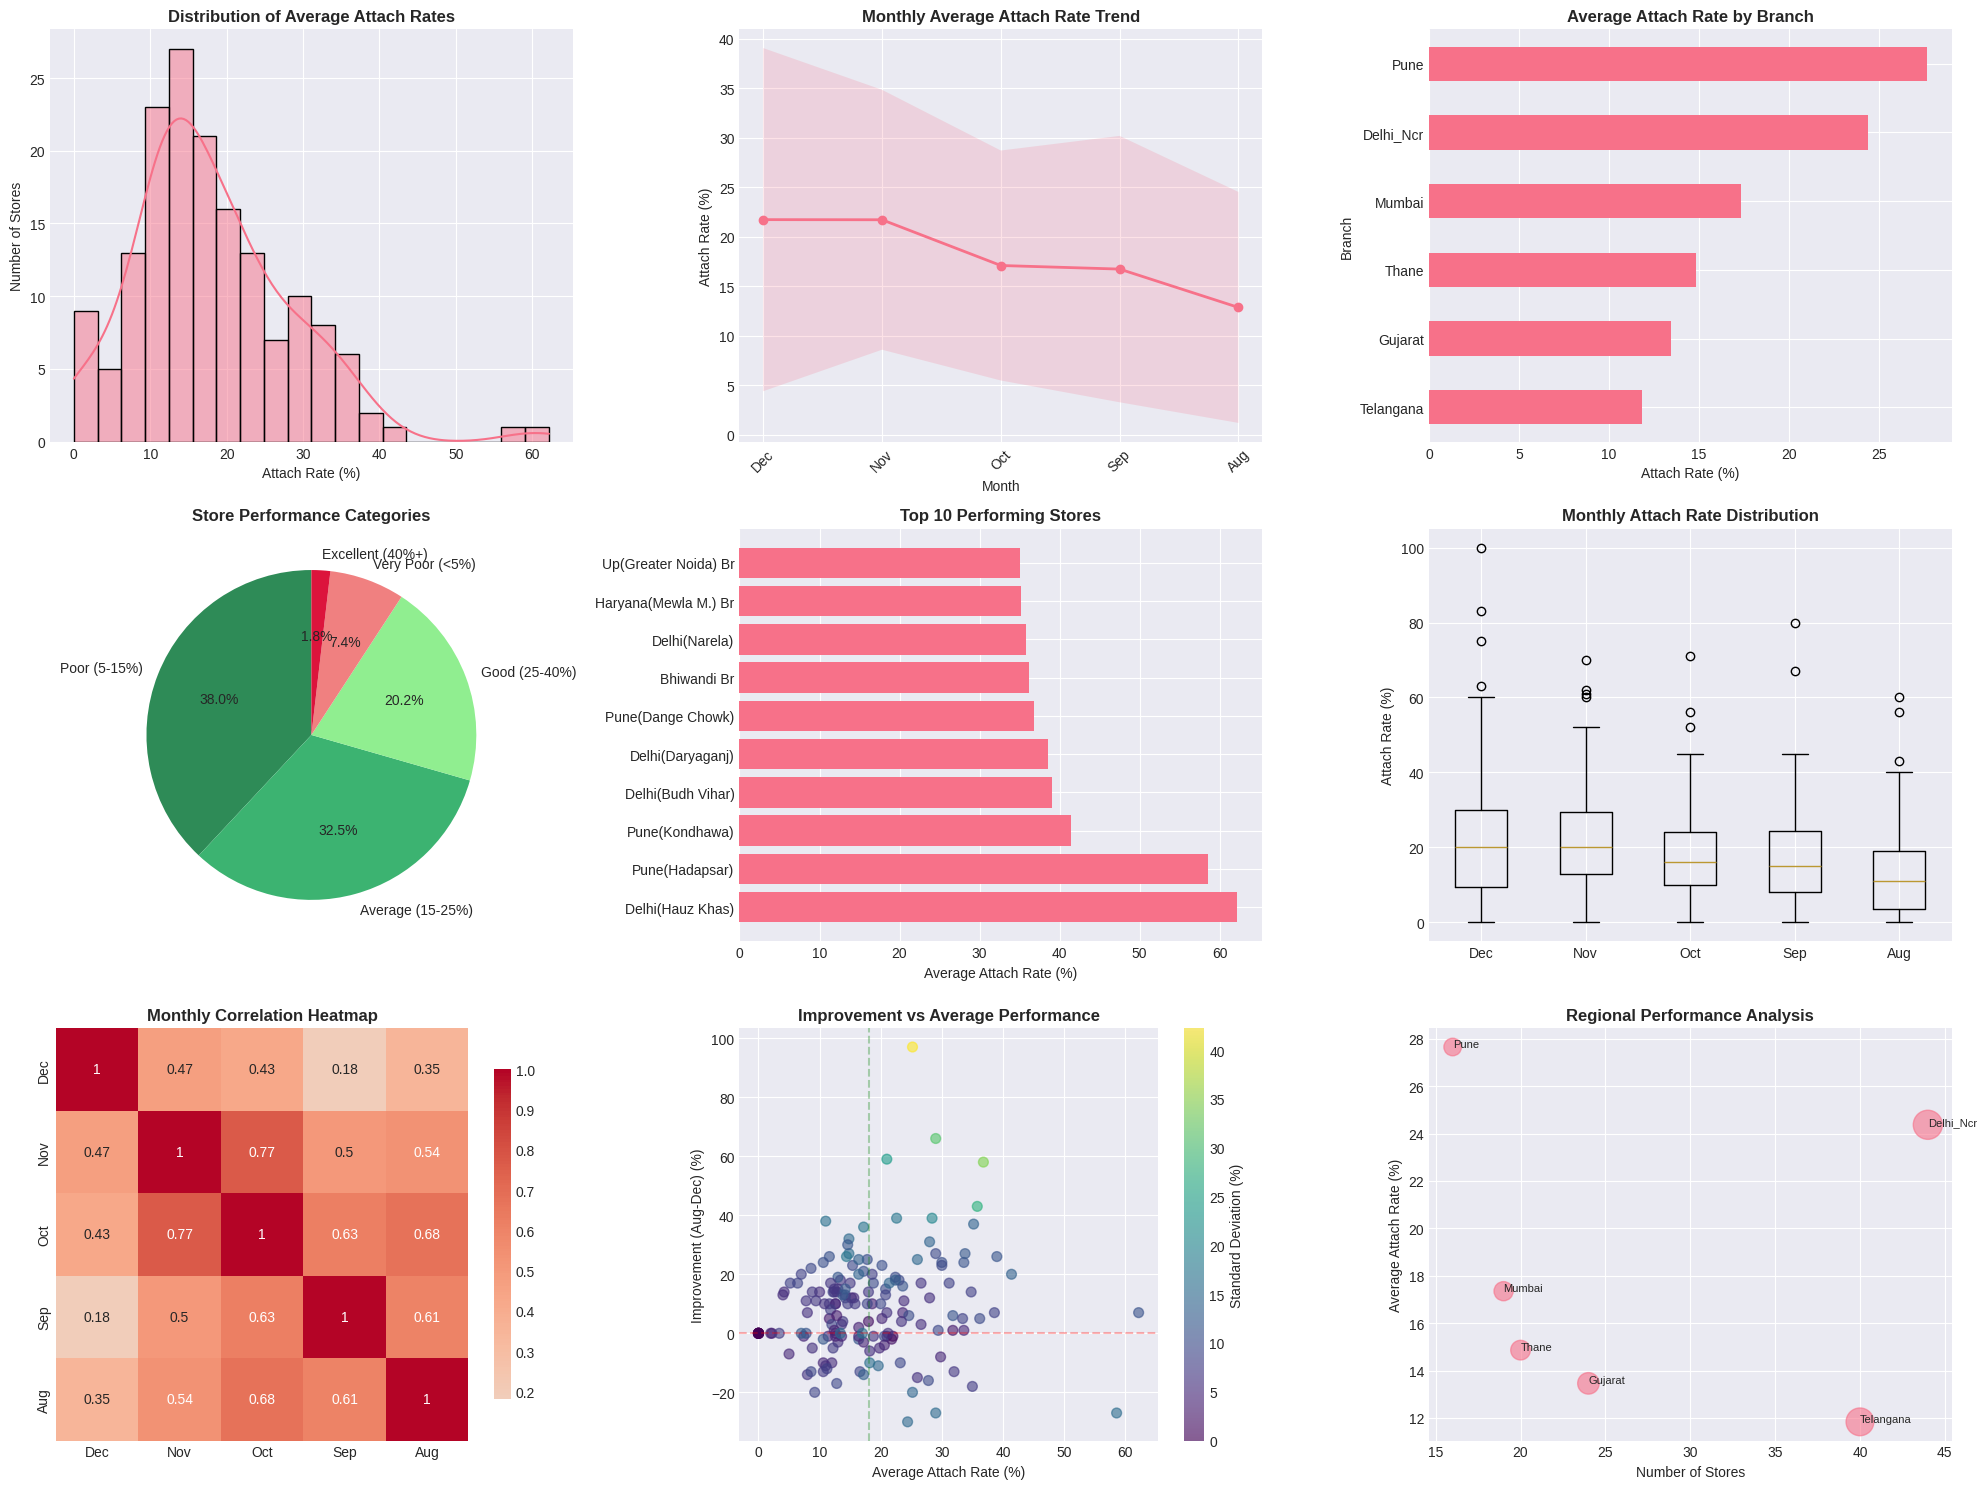


Running prediction model for January attach rates...

JANUARY ATTACH RATE PREDICTION MODEL

Model Performance Comparison:
----------------------------------------

Random Forest:
  MAE:  0.0754
  RMSE: 0.1134
  R²:   -0.1414

Gradient Boosting:
  MAE:  0.0786
  RMSE: 0.1257
  R²:   -0.4012

Linear Regression:
  MAE:  0.0731
  RMSE: 0.1123
  R²:   -0.1193

✓ Selected Best Model: Linear Regression (R²: -0.1193)

PREDICTIONS FOR JANUARY

Top 10 Predicted Stores for January:
--------------------------------------------------
• Pune(Hadapsar)                 (Pune           ): Dec: 33.00% → Jan: 52.55% (Confidence: 64.6%)
• Delhi(Hauz Khas)               (Delhi_Ncr      ): Dec: 63.00% → Jan: 46.80% (Confidence: 74.5%)
• Pune(Dange Chowk)              (Pune           ): Dec: 58.00% → Jan: 46.78% (Confidence: 19.5%)
• Up(Greater Noida) Br           (Delhi_Ncr      ): Dec: 25.00% → Jan: 38.27% (Confidence: 82.2%)
• Delhi(Shahdara) Br             (Delhi_Ncr      ): Dec: 25.00% → Jan: 35.65% (C

In [32]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("Starting Jumbo & Company Device Insurance Analysis...")

    # Generate comprehensive report
    print("\n" + create_analysis_report())

    # Create visualizations
    print("\nGenerating visualizations...")
    create_visualizations()

    # Run prediction model
    print("\nRunning prediction model for January attach rates...")
    df_with_predictions = predict_january_attach()

    # Generate recommendations
    generate_recommendations()

    # Export results
    export_results(df_with_predictions)



if __name__ == "__main__":
    main()